In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import os
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from random import sample
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Installing necessary software
!pip install nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Reading the files and concatenating them into a single dataset
def load_chats():
    df0 = pd.read_excel('LiveChat May 2022.xlsx')
    df1 = pd.read_excel('Live Chat April 2022 .xlsx')
    df2 = pd.read_excel('LiveChat March 2022.xlsx')
    df3 = pd.read_excel('LiveChat February 2022.xlsx')
    df4 = pd.read_excel('LiveChat January 2022.xlsx')
    df5 = pd.read_excel('LiveChat December 2021.xlsx')
    df6 = pd.read_excel('LiveChat November 2021.xlsx')
    df7 = pd.read_excel('LiveChat October 2021 .xlsx')
    df8 = pd.read_excel('LiveChat September 2021.xlsx')
    df_list_asc = [df8, df7, df6, df5, df4, df3, df2, df1, df0]
    return pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8]), df_list_asc

In [ ]:
# Return the list of the names of all the agents involved in the
# given live chat
def get_agent_names(chat):
  agentnames = []
  for text in chat.split("You are now chatting with")[1:]:
    agentnames.append(text.split()[0].split(".")[0])
  return agentnames

# Splitting each of the live chats into agent and student responses
def split_chats(index, df):
  # Initialising variables
  agent_input = []
  student_input = []
  # Retrieving the live chat from given index
  chat = df.iloc[index, 30:31][0]
  # Special case for indices without associated live chat
  if not chat == chat:
    return ['', '', '']
  else:
    agents = get_agent_names(chat)
    # Unfortunately, when the live chat script is bugged, it becomes impossible
    # to tell the agent input from the student input
    if any(len(name) < 3 for name in agents):
      return ['', '', '']
    for line in chat.split("\n"):
      if len(line.split()) > 1:
        # Finding lines of human input via the timestamp, which always comes
        # at the start of the line and contains two colons
        if line.split()[0].count(":") == 2:
          # Identifying the first word of the line which will help us classify
          # it into agent or student input
          first = line.split()[1]
          if first == ":":
            # Some lines will have a superfluous colon after the timestamp; this
            # detects those lines
            first = " ".join(line.split()[2:4])
          # Removing formatting code and superfluous charachters
          clean = re.sub("<.*?>", "", " ".join(line.split()[1:]))
          # Identifying lines of agent input by seeing if the first word of the
          # line is the name of any of the agents
          if first.replace(":","") in agents:
            # Removing agent name labels, which don't constitute useful
            # information, from the agent input
            clean_agent = clean
            for agent in agents:
              clean_agent = clean_agent.replace('%s:' % agent, '')
            agent_input.append(clean_agent)
          elif not ":" in first:
            student_input.append(clean)
    # Recording student email addresses
    student_id = df.iloc[index, 104]
    return ["\n".join(agent_input), "\n".join(student_input), student_id]

In [ ]:
# Defining chats, which consist of both agent and student inputs
class Chat:
  def __init__(self, agent_input, student_input, student_id, content, info):
    self.agent_input = agent_input
    self.student_input = student_input
    self.student_id = student_id
    self.content = content
    self.info = info


# Embedding the size (length) of the response to detect
# bludgeoners via student responses' size later on
class HumanResponses:
  def __init__(self, content, length):
    self.length = length
    self.content = content

# Recording of all the chats, student ids (email addresses), student responses, and agent responses
class PreparedData:
  def __init__(self):
    self.total_categories = 30
    self.chats = []
    self.info_values = [[] for i in range(self.total_categories)]
    self.student_ids = []
    self.student_input_lengths = []  #total volume sent by each student
    self.student_inputs = []
    self.agent_inputs = []

In [ ]:
from pandas.core.describe import DataFrameDescriber
from pandas.core.groupby.groupby import DataError
# Extract useful data from the raw data frames
def prepare_data(dfj):
  data = PreparedData()

  for index in range(len(dfj)):
    agent_input = HumanResponses(split_chats(index, dfj)[0], len(split_chats(index, dfj)[0]))
    student_input = HumanResponses(split_chats(index, dfj)[1], len(split_chats(index, dfj)[1]))
    student_id = split_chats(index, dfj)[2]
    content = dfj.iloc[index, data.total_categories:data.total_categories+1][0]
    info = [category for category in dfj.iloc[index, 0:data.total_categories]]
    chat = Chat(agent_input, student_input, student_id, content, info)
    # Data-cleaning
    if not chat.student_input.length == 0 and student_id == student_id:
      # Recording the info values per index; this will be later used for data
      # cleaning
      for i in range(len(info)):
        data.info_values[i].append(info[i])
      if not student_input.content in data.student_inputs: # Removing duplicates
        data.chats.append(chat)
        data.student_inputs.append(student_input.content)
        data.agent_inputs.append(agent_input.content)
        # Synchronising student email address and total text volume indices
        if not student_id in data.student_ids:
          data.student_ids.append(student_id)
          data.student_input_lengths.append(student_input.length)
        # Updating total text volumes
        else:
          data.student_input_lengths[data.student_ids.index(student_id)] += student_input.length
  return data

In [ ]:
def clean_data(data):
  # Recording the most common info value for each index
  modes = [max(set(data.info_values[i]), key=data.info_values[i].count) for i
         in range(len(data.info_values))]

  # Computing the state spaces for all the catergories
  state_space = [[] for i in range(len(data.info_values))]
  for chat in data.chats:
    for i in range(len(chat.info)):
      if chat.info[i] not in state_space[i] and chat.info[i] == chat.info[i]:
        state_space[i].append(chat.info[i])

  # Indices of categories with state spaces that are neither too small nor too large
  # to be useful, and whose most common value isn't "missing data"
  indices_clean = [i for i in range(len(data.info_values)) if len(state_space[i]) > 1
   and len(state_space[i]) < 0.5*len(data.chats) and modes[i] == modes[i]]
  # Filtering the modes and state space through indices_clean
  modes_clean = [modes[i] for i in range(len(modes)) if i in indices_clean]
  state_space_clean = [state_space[i] for i in range(len(state_space)) if i
                     in indices_clean]

  # Replacing nan values with the most common value for the corresponding category,
  # as well as removing categories filtred by indices_clean
  for chat in data.chats:
    info = [chat.info[i] for i in range(len(chat.info)) if i in indices_clean]
    for i in range(len(info)):
      if not info[i] == info[i]:
        info[i] = modes_clean[i]
    chat.info = info

In [ ]:
# Preliminarily defining bludgeoners as those students who send a statistically
# outlying volume of text, and bludgeoner chats as those involving bludgeoners
def compute_preliminary_bludgeoners(data):
  bludgeoners = []
  for email in data.student_ids:
    if data.student_input_lengths[data.student_ids.index(email)] > (np.quantile(data.student_input_lengths, 0.75)
      + 1.5*(np.quantile(data.student_input_lengths, 0.75)-np.quantile(data.student_input_lengths, 0.25))):
      bludgeoners.append(email)

  bludgeoner_chats = [chat for chat in data.chats if chat.student_id in bludgeoners]
  return bludgeoners, bludgeoner_chats

In [ ]:
# Function to randomly split the bludgeoner chats into 2 groups of equal size,
# and to concatenate each group with a random sample of non-bludgeoner chats of
# the size of choice, then create all the relevant variables
def create_inputs_and_indices(coeff, data, bludgeoner_chats):
  bludgeoner_indices = [i for i in range(len(data.chats)) if data.chats[i] in bludgeoner_chats]
  global non_bludgeoner_indices
  non_bludgeoner_indices = [i for i in range(len(data.chats)) if data.chats[i]
                            not in bludgeoner_chats]
  bludgeoner_indices_1 = sample(bludgeoner_indices, int(0.5*len(bludgeoner_chats)))
  bludgeoner_indices_2 = [i for i in bludgeoner_indices if i
                          not in bludgeoner_indices_1]
  non_bludgeoner_indices_1 = sample(non_bludgeoner_indices,
                                    int(coeff))
  non_bludgeoner_indices_2 = sample([i for i in non_bludgeoner_indices if i
                                    not in non_bludgeoner_indices_1],
                                    int(coeff))
  indices_1 = bludgeoner_indices_1 + non_bludgeoner_indices_1
  indices_2 = bludgeoner_indices_2 + non_bludgeoner_indices_2
  shuffle(indices_1) # Random shuffling is important to reduce model bias
  shuffle(indices_2)

  test_indices_1 = [i for i in range(len(data.chats)) if i not in indices_1]
  test_indices_2 = [i for i in range(len(data.chats)) if i not in indices_2]

  global student_input_1
  global student_input_2
  global student_input_test_1
  global student_input_test_2
  student_input_1 = [data.student_inputs[i] for i in indices_1]
  student_input_2 = [data.student_inputs[i] for i in indices_2]
  student_input_test_1 = [data.student_inputs[i] for i in test_indices_1]
  student_input_test_2 = [data.student_inputs[i] for i in test_indices_2]

  global is_bludgeoner_1
  global is_bludgeoner_2
  global is_bludgeoner_test_1
  global is_bludgeoner_test_2
  is_bludgeoner_1 = [int(data.chats[i] in bludgeoner_chats) for i in indices_1]
  is_bludgeoner_2 = [int(data.chats[i] in bludgeoner_chats) for i in indices_2]
  is_bludgeoner_test_1 = [int(data.chats[i] in bludgeoner_chats) for i in test_indices_1]
  is_bludgeoner_test_2 = [int(data.chats[i] in bludgeoner_chats) for i in test_indices_2]

  global bludgeoner_list
  def bludgeoner_list(chats):
    if chats == student_input_1:
      return is_bludgeoner_1
    if chats == student_input_2:
      return is_bludgeoner_2

  global get_test_inputs
  def get_test_inputs(chats):
    if chats == student_input_1:
      return student_input_test_1
    if chats == student_input_2:
      return student_input_test_2

# Loading and preparing the data, to create two balanced samples
dfj, df_list = load_chats()
data = prepare_data(dfj)
clean_data(data)
bludgeoners, bludgeoner_chats = compute_preliminary_bludgeoners(data)
create_inputs_and_indices(int(0.5*len(bludgeoner_chats)), data, bludgeoner_chats)

In [ ]:
# Initialising ML bludgeoner classifier components
tokeniser = RegexpTokenizer(pattern = '\w+')
stopwords = nltk.corpus.stopwords.words("english")
ps = PorterStemmer()

In [ ]:
# Preparing a clean piece of text ready for vectorisation
def get_stemmed_tokens(text, get_tokens = False):
  text = text.lower()
  tokens = tokeniser.tokenize(text)
  # Removing stopwords, which aren't useful for bludgeoner classification
  clean_tokens = [token for token in tokens if token not in stopwords
                  and not any(x in token for x in ["xx", "_"])]
  stemmed_tokens = [ps.stem(token) for token in clean_tokens]
  if not get_tokens:
    return " ".join(stemmed_tokens)
  # Creating a second purpose for the function to break down a piece of text into
  # a list of clean words and symbols
  else:
    return stemmed_tokens

# Generating the list of all words known to us so far in preparation for training
# our bludgeoner classification model
def vocab(chats):
  vocab = []
  for chat in chats:
    for token in get_stemmed_tokens(chat, True):
      if token not in vocab:
        vocab.append(token)
  return vocab

# Writing a function to filter out words which aren't in our vocabulary, as the
# vocab vector that we will later use for model training will not contain
# a slot associated with those words
def filter_tokens_by_vocabulary(text, chats):
  voc = vocab(chats)
  text_new = []
  for token in get_stemmed_tokens(text, True):
    if token in voc:
      text_new.append(token)
  return " ".join(text_new)

# Function to return machine-learning-ready data
def pre_process_chats(input_chats, chats, vct):
  clean_chats = [get_stemmed_tokens(chat) for chat in input_chats]
  if not data == chats:
    clean_chats = [filter_tokens_by_vocabulary(chat, chats) for chat in input_chats]

  vector = vct.fit_transform(clean_chats).toarray()
  return np.array(vector)

# Training a neural network to detect preliminarily defined bludgeoners from
# student input chat data
def predicted_bludgeoners(chats):
  tv = TfidfVectorizer(ngram_range = (1, 3), vocabulary = vocab(chats))
  model = MLPClassifier()
  model.fit(pre_process_chats(chats, chats, tv), bludgeoner_list(chats))
  return model.predict(pre_process_chats(get_test_inputs(chats), chats, tv))

In [ ]:
# Recording the neural network's predictions
test_1_pred_balanced = predicted_bludgeoners(student_input_1)
test_2_pred_balanced = predicted_bludgeoners(student_input_2)

is_bludgeoner_test_1_balanced = is_bludgeoner_test_1
is_bludgeoner_test_2_balanced = is_bludgeoner_test_2

# Creating a different sample with a population-representative distribution skew
create_inputs_and_indices(int(0.5*len(non_bludgeoner_indices)), data, bludgeoner_chats)
test_1_pred_skew = predicted_bludgeoners(student_input_1)
test_2_pred_skew = predicted_bludgeoners(student_input_2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
# Function to return the number of false and true positives in the
# neural network's predictions
def positives(true, pred):
  # Creating a global variable which records the indices of true positive
  # predictions for later use in the redefinition of bludgeoner chats
  global true_positive_indices
  true_positive_indices = []
  false_positive = 0
  true_positive = 0
  for i in range(len(pred)):
    if pred[i] == 1:
      if pred[i] == true[i]:
        true_positive += 1
        true_positive_indices.append(i)
      else:
        false_positive += 1
  return [false_positive, true_positive]

In [ ]:
# Checking the accuracy of the neural network's predictions to
# determine if they are suitable for use
pb_1 =  positives(is_bludgeoner_test_1_balanced, test_1_pred_balanced)
print("""Test 1 balanced:
False positives:""", pb_1[0], "True positives:", pb_1[1])
ind_1_b = true_positive_indices

pb_2 =  positives(is_bludgeoner_test_2_balanced, test_2_pred_balanced)
print("""Test 2 balanced:
False positives:""", pb_2[0], "True positives:", pb_2[1])
ind_2_b = true_positive_indices

ps_1 =  positives(is_bludgeoner_test_1, test_1_pred_skew)
print("""Test 1 skew:
False positives:""", ps_1[0], "True positives:", ps_1[1])
ind_1_s = true_positive_indices

ps_2 =  positives(is_bludgeoner_test_2, test_2_pred_skew)
print("""Test 2 skew:
False positives:""", ps_2[0], "True positives:", ps_2[1])
ind_2_s = true_positive_indices

print("Test 1 balanced accuracy:",
      balanced_accuracy_score(is_bludgeoner_test_1_balanced, test_1_pred_balanced),
      "Test 1 balanced sensitivity:",
      pb_1[1]/(pb_1[0] + pb_1[1]),
      "\nTest 2 balanced accuracy:",
      balanced_accuracy_score(is_bludgeoner_test_2_balanced, test_2_pred_balanced),
      "Test 2 balanced sensitivity:",
      pb_2[1]/(pb_2[0] + pb_2[1]),
      "\nTest 1 skew accuracy:",
      balanced_accuracy_score(is_bludgeoner_test_1, test_1_pred_skew),
      "Test 1 skew sensitivity:",
      ps_1[1]/(ps_1[0] + ps_1[1]),
      "\nTest 2 skew accuracy:",
      balanced_accuracy_score(is_bludgeoner_test_1, test_1_pred_skew),
      "Test 2 skew sensitivity:",
      ps_2[1]/(ps_2[0] + ps_2[1]))

Test 1 balanced:
False positives: 603 True positives: 148
Test 2 balanced:
False positives: 511 True positives: 148
Test 1 skew:
False positives: 94 True positives: 71
Test 2 skew:
False positives: 84 True positives: 70
Test 1 balanced accuracy: 0.6483322952685724 Test 1 balanced sensitivity: 0.1970705725699068 
Test 2 balanced accuracy: 0.681593322022007 Test 2 balanced sensitivity: 0.22458270106221548 
Test 1 skew accuracy: 0.616473974005219 Test 1 skew sensitivity: 0.4303030303030303 
Test 2 skew accuracy: 0.616473974005219 Test 2 skew sensitivity: 0.45454545454545453


In [ ]:
# Even though the balanced method yielded a higher balanced accuracy, sensitivity
# was the metric of choice,and the skew method yielded a significantly higher
# sensitivity. Therefore, I will proceed with the skew method classification.
ind_1 = ind_1_s
ind_2 = ind_2_s

In [ ]:
# Since the neural network peformance was demonstrated to be satisfactory,
# preliminarily defining bludgeoner chats as those that are classified as such
# by both the preliminary heuristic and the neural network; then redefining
# bludgeoners as those students who were involved in bludgeoner chats; and
# finally redefining bludgeoner chats as those that involved bludgeoners.
bludgeoner_inputs_prelim = [student_input_test_1[ind]
                            for ind in ind_1] + [student_input_test_2[ind]
                                                 for ind in ind_2]
bludgeoner_chats_prelim = [chat for chat in bludgeoner_chats if chat.student_input.content
                        in bludgeoner_inputs_prelim]
bludgeoners_new = np.unique([chat.student_id for chat in bludgeoner_chats_prelim])
bludgeoner_chats_new = [chat for chat in data.chats if chat.student_id in bludgeoners_new]
bludgeoner_inputs = [chat.student_input.content for chat in bludgeoner_chats_new]
student_input_lengths_new = [data.student_input_lengths[data.student_ids.index(id)] for id in bludgeoners]

In [ ]:
# Building a model to to detect bludgeoners from agent responses; since the skewed
# split approach proved to yield a higher sensitivity, I will use this approach
# in this case as well
x = data.agent_inputs
y = [int(chat in bludgeoner_chats_new) for chat in data.chats]
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 0)

# Function to train the neural network from agent responses
def predicted_bludgeoners_from_agent_input(test):
  tv = TfidfVectorizer(ngram_range = (1, 3), vocabulary = vocab(x_train))
  model = MLPClassifier()
  model.fit(pre_process_chats(x_train, x_train, tv), y_train)
  return model.predict(pre_process_chats(test, x_train, tv))

In [ ]:
# Training the neural network from agent responses
agent_pred = predicted_bludgeoners_from_agent_input(x_test)

# Measuring the accuracy of the predictions
print("Balanced accuracy:", balanced_accuracy_score(y_test, agent_pred))

# Measuring the sensitivity of the predictions
pa = positives(y_test, agent_pred)
print("Sensitivity:", pa[1]/(pa[0] + pa[1]))

Balanced accuracy: 0.6218390804597701
Sensitivity: 0.4426229508196721


In [ ]:
# Building a model that identifies bludgeoners from information about the student
x = [chat.info for chat in data.chats]
# Splitting the sample into train and test data
info_train, info_test, output_train, output_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [ ]:
# Function to compute the accuracy of a given model
def model_accuracy(x_train, x_test, y_train, y_test, classifier, grid = {},
                   iterations = 1):
  # Initialising variable
  scores = []
  # Performing parameter grid search with 5-fold cross-validation a specified
  # number of times; randomised search is performed for computationally heavy
  # models
  for i in range(iterations):
    grid_search = GridSearchCV(estimator = classifier,
                              param_grid = grid,
                              n_jobs=-1,
                              cv = 5,
                              scoring = "recall").fit(x_train, y_train)
    # Recording the best parameter combination and corresponding score for
    # each iteration
    scores.append([grid_search.best_score_, grid_search.best_estimator_])
    # Finding the parameter combination which produces the best yield most often
    best_params = max(set([i[1] for i in scores]), key=scores.count)
    # Recording the yield of the best parameter combination
    best_yield = np.mean([i[0] for i in scores if i[1] == best_params])
  return [best_params, best_yield]

# Function to return classification-ready data
def encode(train, test):
  ohe = OneHotEncoder(handle_unknown = 'ignore')
  ohe.fit(train)
  return [ohe.transform(train).toarray(), ohe.transform(test).toarray()]

In [ ]:
# Finding the best hyperparameters; I will use a neural network, since it has
# proven to be the most suitable for imbalanced datasets
x_train_enc, x_test_enc = encode(info_train, info_test)
model_info = model_accuracy(x_train_enc, x_test_enc,output_train, output_test,
              MLPClassifier(),
              {"activation" : ["logistic", "tanh", "relu"],
              "solver" : ["lbfgs", "sgd", "adam"],
              "max_iter" : [500]}, 1) # Only 3 iterations due to computational strain
print(model_info)

[MLPClassifier(activation='tanh', max_iter=500), 0.5399577167019027]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
# Function to apply the model on given data
def get_predictions(x_train, x_test, y_train, y_test):
  x_train_enc, x_test_enc = encode(info_train, info_test)
  model = model_info[0]
  model.fit(x_train_enc, x_train)
  return model.predict(x_test_enc)

In [ ]:
from scipy.stats.distributions import norm_gen
# Counting the number of bludgeoners, as well as the number of bludgeoner chats,
# in each month
bludgeoner_chat_counts = []
bludgeoner_counts = []
ID_counts = [] # Recording the total number of IDs per dataset for later use in
# bludgeoner pecentage calculations
chat_counts = [] # Recording the total number of chats for later use in bludgeoner
# chat percentage caclulations

dataframes = df_list
for df in dataframes:
  t_count = 0 # Total chat count
  b_count = 0 # Bludgeoner chat count
  bludgeoner_IDs = []
  IDs = []
  for index in range(len(df)):
    spl = split_chats(index, df)
    if not len(spl[1]) == 0 and spl[2] == spl[2]: # Data-cleaning
      t_count += 1
      if not spl[2] in IDs:
        IDs.append(spl[2])
      if spl[1] in bludgeoner_inputs:
        b_count += 1
        if not spl[2] in bludgeoner_IDs:
          bludgeoner_IDs.append(spl[2])
  chat_counts.append(t_count)
  bludgeoner_chat_counts.append(b_count)
  bludgeoner_counts.append(len(bludgeoner_IDs))
  ID_counts.append(len(IDs))

# Student ID data completely missing from the April dataset, so all April data
# will be replaced by the mean of its neighbours
chat_counts[7] = np.mean([chat_counts[6], chat_counts[8]])
bludgeoner_chat_counts[7] = np.mean([bludgeoner_chat_counts[6],
                                     bludgeoner_chat_counts[8]])
bludgeoner_counts[7] = np.mean([bludgeoner_counts[6], bludgeoner_counts[8]])
ID_counts[7] = np.mean([ID_counts[6], ID_counts[8]])

# Calculating the monthly pecentages of bludgeoners and bludgeoner chats out of all
# students and chats, respectively
percentage_chats = [(bludgeoner_chat_counts[i]/chat_counts[i])*100 for i in range(9)]
percentage_bludgeoners = [(bludgeoner_counts[i]/ID_counts[i])*100 for i in range(9)]
months = ["Sep 2021", "Oct 2021", "Nov 2021", "Dec 2021", "Jan 2022", "Feb 2022",
          "Mar 2022", "Apr 2022", "May 2022"]

# Normalising the data
norm_bcc = preprocessing.normalize([bludgeoner_chat_counts])[0]
norm_bc = preprocessing.normalize([bludgeoner_counts])[0]
norm_pc = preprocessing.normalize([percentage_chats])[0]
norm_pb = preprocessing.normalize([percentage_bludgeoners])[0]
norm_cc = preprocessing.normalize([chat_counts])[0]
norm_ic = preprocessing.normalize([ID_counts])[0]

In [ ]:
# Computing various relevant statistics
lengths_total = [chat.student_input.length for chat in data.chats]
global_percentage_bludgeoners = (len(bludgeoners_new)/len(data.student_ids))*100
percentage_chatacters = sum(student_input_lengths_new)/sum(lengths_total)*100
global_percentage_chats = len(bludgeoner_chats_new)/len(data.chats)*100

# Function to return a list containing how much time was spent on each chat, as
# well as how much time was spent on each bludgeoner chat specifically
def time_spent_per_chat(df):
  time_spent_on_chat = []
  time_spent_on_bludgeoner_chat = []
  for index in range(len(df)):
    chat = df.iloc[index, 30:31][0]
    if df.iloc[index, 104] in data.student_ids and chat == chat:
      time_spent = df.iloc[index, 11]
      time_spent_on_chat.append(time_spent)
      if df.iloc[index, 104] in bludgeoners_new:
        time_spent_on_bludgeoner_chat.append(time_spent)
  return [time_spent_on_chat, time_spent_on_bludgeoner_chat]

time_spent = time_spent_per_chat(dfj)
percentage_time_spent_on_bludgeoners = len(time_spent[1])/len(time_spent[0])*100

print("""Despite making up only %s%% of all students, bludgeoners contribute %s%%
of all student input, initiate %s%% of the live chats, and use up %s%% of the agents'
time.""" % (round(global_percentage_bludgeoners), round(percentage_chatacters),
           round(global_percentage_chats), round(percentage_time_spent_on_bludgeoners)))

# Testing if the results are statistically significant
sqrt_n = (len(bludgeoners_new))**0.5
a_t = sum(time_spent[1])/len(bludgeoners_new)
z_t = (a_t-np.mean(time_spent[0]))/(np.std(time_spent[0])/sqrt_n)
z_c = (np.mean(student_input_lengths_new)-np.mean(lengths_total)/(np.std(lengths_total)/sqrt_n))

# 1.64 is the critical value for the standard normal distribution at the 5%
# significance level
print("Time spent percentage statistically significant? %s" % (z_t > 1.96))
print("Chat percentage result statistically significant? %s" % (z_c > 1.96))


Despite making up only 5% of all students, bludgeoners contribute 33%
of all student input, initiate 15% of the live chats, and use up 16% of the agents'
time.
Time spent percentage statistically significant? True
Chat percentage result statistically significant? True


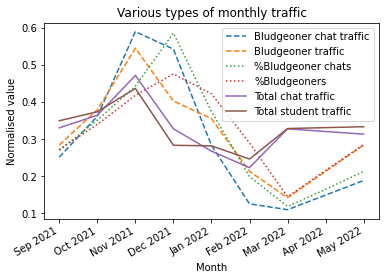

In [ ]:
# Plotting number of bludgeoners against time
fig, ax = plt.subplots()
ax.plot(months, norm_bcc, label = 'Bludgeoner chat traffic', linestyle = '--')
ax.plot(months, norm_bc, label = 'Bludgeoner traffic', linestyle = '--')
ax.plot(months, norm_pc, label = '%Bludgeoner chats', linestyle = ':')
ax.plot(months, norm_pb, label = '%Bludgeoners', linestyle = ':')
ax.plot(months, norm_cc, label = 'Total chat traffic')
ax.plot(months, norm_ic, label = 'Total student traffic')
ax.set_ylabel('Normalised value')
ax.set_xlabel('Month')
ax.set_title('Various types of monthly traffic')

fig.autofmt_xdate()
plt.legend()
plt.show()

As we can see from the data, bludgeoner and bludgeoner chat trends appear to be close to identical, so we can pick either one of the two for our model. Both of the trends appear to be quasi-sinusoidal, which is possibly indicative of seasonality; however, without additional data from more than one season, it is impossible to conclusively verify that.

Additionally, bludgeoner percentage appears to be correlated with total student traffic; the two quasi-sinusoids constructively interfere to create a similar total bludgeoner traffic trend with a greater amplitude. This correlation is worth investigating.

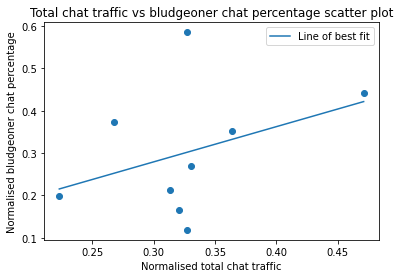

Correlation: 0.37611118398613613; 14% of the variance in bludgeoner chat percentage 
explained by variance in total chat traffic.


In [ ]:
# Drawing a scatter plot to examine the correlation between total chat traffic
# and bludgeoner chat percentage
fig, ax = plt.subplots()
ax.scatter(norm_cc, norm_pc)
ax.plot(np.unique(norm_cc),
        np.poly1d(np.polyfit(norm_cc, norm_pc, 1))(np.unique(norm_cc)),
        label = "Line of best fit")
ax.set_ylabel('Normalised bludgeoner chat percentage')
ax.set_xlabel('Normalised total chat traffic')
ax.set_title('Total chat traffic vs bludgeoner chat percentage scatter plot')

plt.legend()
plt.show()

# Computing the coefficients of correlation and determination
cc = np.corrcoef(norm_cc, norm_pc)[0, 1]
cd = (cc**2)*100

print("""Correlation: %s; %d%% of the variance in bludgeoner chat percentage
explained by variance in total chat traffic.""" % (cc, cd))

As demonstrated by the scatter plot and the correlation coefficient, there is a moderate correlation between total chat traffic and bludgeoner chat percentage. Therefore, if the total chat traffic can be accurately predicted, it will help build a more reliable estimate of bludgeoner chat traffic.

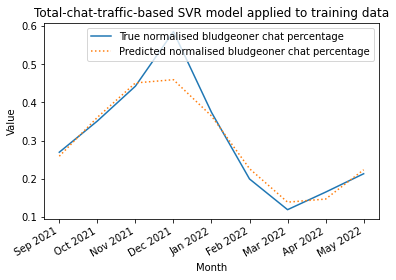

In [ ]:
# RBF-based SVR model given total chat traffic can be accurately predicted
model = SVR(epsilon = 0.01)
model.fit(np.array([[month, norm_cc[month]] for month in range(9)]), norm_pc)
pred = model.predict(np.array([[month, norm_cc[month]] for month in range(9)]))

# Due to insufficient data, we won't be able to test the model effectively;
# however, demonstrated below is the model applied to the data it was trained on.
fig, ax = plt.subplots()
ax.plot(months, norm_pc, label = 'True normalised bludgeoner chat percentage')
ax.plot(months, pred, label = 'Predicted normalised bludgeoner chat percentage',
        linestyle = ':')
ax.set_ylabel('Value')
ax.set_xlabel('Month')
ax.set_title('Total-chat-traffic-based SVR model applied to training data')

fig.autofmt_xdate()
plt.legend()
plt.show()

On the other hand, if total chat traffic cannot be accurately predicted, then date is the only remaining known factor; in this case, time series analysis is appropriate.

Given that, as described earlier, seasonality is plausible, the SARIMA model would normally be applicable. However, if we assume the period of seasonality to be 12 months, then we only have data for less than one season, which would make the SARIMA model redudant. Therefore, until more data are available, the ARIMA model will be used.

To fit the model on the time series, we first need to verify that the series is stationary.

In [ ]:
# Running an adfuller test at the 5% confidence level to determine if the series
# is stationary
print("p-value:", adfuller(norm_bcc)[1])
print("Sufficient evidence:", adfuller(norm_bcc)[1] < 0.05)

p-value: 0.07131531593803354
Sufficient evidence: False


There is sufficient evidence to definitively conclude that the series is stationary. Therefore, an integrated order of 0 will selected.

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


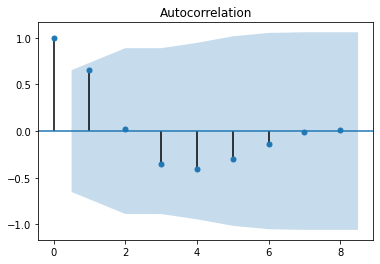

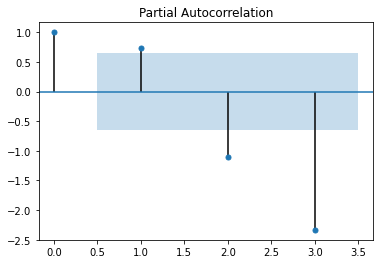

In [ ]:
# Plotting the ACF and PACF values to determine the suitable order of the AR and
# MA parts
fig = plt.figure
fig = plot_acf(np.array(norm_bcc))
fig = plot_pacf(np.array(norm_bcc), lags = 3)

On both plots, the autocorrelation at lag 1 is positive, and on the PACF plot, there is no sign of gradual decay. Both of these are AR signatures; the exact AR order will be determined via QCA (qualitative comparative analysis).

On the ACF plot, the decay is gradual, which suggests that no additional MA terms should be added. Hence, an MA order of 0 will be selected.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


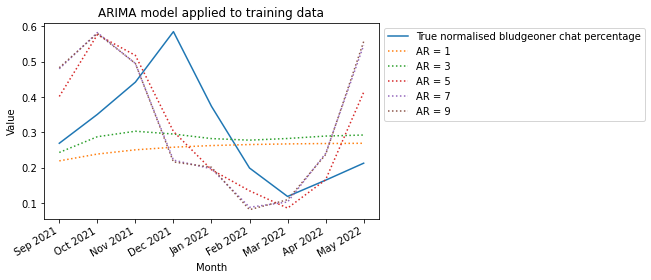

In [ ]:
# Plotting the model with the above-selected MA and I orders as well as with a
# range of AR orders applied on the training data
fig, ax = plt.subplots()
ax.plot(months, norm_pc, label = 'True normalised bludgeoner chat percentage')
for i in [1, 3, 5, 7, 9]:
  model = ARIMA(norm_bcc, order = [i, 0, 0])
  pred = model.fit().forecast(len(norm_bcc))
  ax.plot(months, pred, label = 'AR = %s' % i,
          linestyle = ':')
ax.set_ylabel('Value')
ax.set_xlabel('Month')
ax.set_title('ARIMA model applied to training data')

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

AR = 5 fits the data best; therefore, an AR order of 5 will be selected. Note that the fit isn't perfect; that's likely a consequence of insufficient data.

Hence, here are the final two models applied on the training data and plotted alongside it:

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


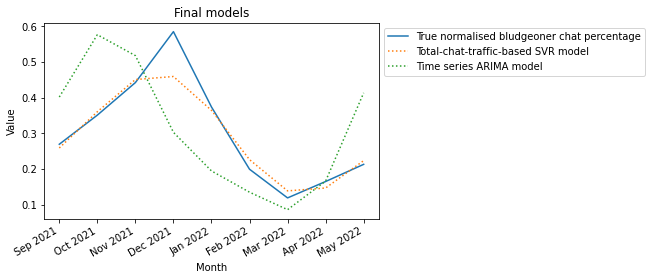

In [ ]:
model = SVR(epsilon = 0.01)
model.fit(np.array([[month, norm_cc[month]] for month in range(9)]), norm_pc)
pred_SV = model.predict(np.array([[month, norm_cc[month]] for month in range(9)]))

model = ARIMA(norm_bcc, order = [5, 0, 0])
pred_AR = model.fit().forecast(len(norm_bcc))

fig, ax = plt.subplots()
ax.plot(months, norm_pc, label = 'True normalised bludgeoner chat percentage')
ax.plot(months, pred_SV, label = 'Total-chat-traffic-based SVR model',
        linestyle = ':')
ax.plot(months, pred_AR, label = 'Time series ARIMA model',
          linestyle = ':')
ax.set_ylabel('Value')
ax.set_xlabel('Month')
ax.set_title('Final models')

fig.autofmt_xdate()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

We can also use the time series model to forecast future bludgeoner chat traffic:


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


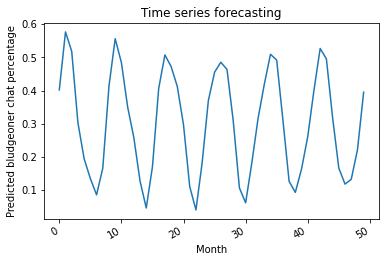

In [ ]:
model = ARIMA(norm_bcc, order = [5, 0, 0])
pred_future = model.fit().forecast(50)

fig, ax = plt.subplots()
ax.plot(range(50), pred_future, label = 'Forecast')
ax.set_ylabel('Predicted bludgeoner chat percentage')
ax.set_xlabel('Month')
ax.set_title('Time series forecasting')

fig.autofmt_xdate()